In [54]:
import numpy as np
import pandas as pd
import datetime as dt
import time
from sklearn.model_selection import train_test_split
from __future__ import division

# Get the data

In [55]:
filename = 'Algorithms_Data.csv'
data = pd.read_csv(filename)
data = data[-15000:]  # Training on more than this doesn't seem to improve results, but takes longer
targets = data['Win']
data = data[['fran_elo', 'opp_elo', 'RollAvg_A_5_pts', 'RollAvg_B_5_pts', 'RollAvg_A_5_opp_pts', 'RollAvg_B_5_opp_pts', 'Days_Since_Last']]

In [56]:
pd.concat([data.head(), targets.head()], axis=1)

,fran_elo,opp_elo,RollAvg_A_5_pts,RollAvg_B_5_pts,RollAvg_A_5_opp_pts,RollAvg_B_5_opp_pts,Days_Since_Last,Win
32530,1489.768214,1684.042297,91.8,95.2,96.2,86.8,1.0,False
32531,1569.508971,1558.067109,83.8,93.2,77.4,84.4,1.0,False
32532,1687.615767,1528.192875,107.2,98.2,94.2,92.2,1.0,False
32533,1509.910406,1448.525491,101.2,100.0,106.8,97.6,1.0,False
32534,1456.563819,1571.171564,97.4,93.6,91.2,83.6,3.0,False


The above table is a sample of the data we will be using in order to predict whether the home team will win an NBA basketball game. Each row represents one match up between two basketball teams. Team A is the away team, team B is the home team.  Note a value of False in the Win column implies that team B (the home team) won.

The ELO rating system is a method for calculating the relative skill levels of players in two-player games such as chess. We have adapted this system in order to measure skill levels of different NBA teams based on their recent performance.  We computed the ELO ratings for each team over the history of our dataset, and we use this as a feature.

A_elo: The ELO ranking for the away team (A) at the time this game was played.

B_elo: The ELO ranking for the home team (B) at the time this game was played.

RollAvg_A_5_pts: For the away team, the average points this specific team has scored in their last 5 games.

RollAvg_B_5_pts: For the home team, the average points this specific team has scored in their last 5 games.

RollAvg_A_5_opp_pts: For the home team, the average points this specific team has allowed in their last 5 games.

RollAvg_B_5_opp_pts: For the away team, the average points this specific team has allowed in their last 5 games.

Days_Since_Last: Number of days since the away team last played a game.

For more information on the ELO scores, see our Machine Learning page.

In [57]:
def runAlgorithm(model, trials=10,):
    """ Run a given machine learning algorithm on globally defined data.
       Splits data randomly into test and training sets.
       Returns the average time and accuracy.
   
   :param model: A sklearn model initialized with parameters.
   :param trials: Number of trials to run.  Defaults to 10.
   """
   
    t1 = []
    t2 = []
    preds =[]
    for t in range(trials):
        X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=.2)
        t1.append(time.time())

        model.fit(X_train, y_train)
        preds.append(np.mean((model.predict(X_test)>.5) == y_test))
        t2.append(time.time())

    return (np.mean(preds),np.mean(np.array(t2)-np.array(t1))),preds


import matplotlib.pyplot as plt

def plotDist(results,bins=25):
    plt.hist(results, bins=bins)
    plt.show()

# Application of ML algorithms

## Baseline
Guess that the home team wins every game.  If a method doesn't do better than this, it isn't learning much.

In [78]:
t1 = []
t2 = []
preds = []
for t in range(10):
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=.2)
    t1.append(time.time())

    preds.append((np.zeros(len(y_test)) == y_test).mean())
    t2.append(time.time())

baseline_ = (np.mean(preds), np.mean(np.array(t2)-np.array(t1))), preds
print 'Accuracy: {}\nTime: {}'.format(*baseline_[0])

Accuracy: 0.5978
Time: 0.000546193122864


## SVM

Accuracy: 0.661773333333
Time: 4.61604221821


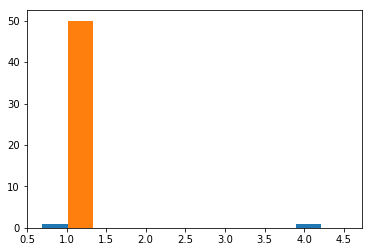

In [59]:
from sklearn import svm
from sklearn import preprocessing

accuracy = []
times = []
for i in xrange(50):
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=.2)
    X = preprocessing.scale(X_train)
    s = time.time()
    SVM_model = svm.SVC(C=10**-5, kernel='poly', coef0=0, gamma=10**-2).fit(X, y_train)
    preds = SVM_model.predict(X_test)
    prob = np.sum(preds == y_test)/len(y_test)
    times.append(time.time() - s)
    accuracy.append(prob)

svm_r = (np.mean(accuracy), np.mean(times)), accuracy
print 'Accuracy: {}\nTime: {}'.format(*svm_r[0])


In [ ]:
plotDist(svm_r[1],5)

## Logistic Regression

Accuracy: 0.759353333333
Time: 0.0377923526764


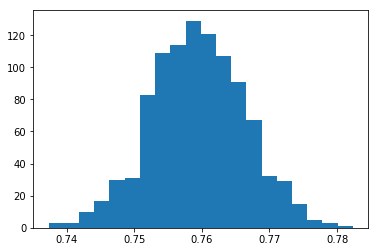

In [60]:
from sklearn import linear_model as lm

lam = 10**2

model = lm.LogisticRegression(C=np.abs(1/lam))
log_reg = runAlgorithm(model, trials=1000)
print 'Accuracy: {}\nTime: {}'.format(*log_reg[0])
plotDist(log_reg[1],20)

## Ridge Regression 

Accuracy: 0.759165666667
Time: 0.0432551960945


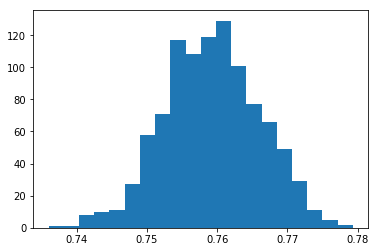

In [61]:
from sklearn.linear_model import Ridge as ri

skRidge = ri()
rid_reg = runAlgorithm(model,trials = 1000)
print 'Accuracy: {}\nTime: {}'.format(*rid_reg[0])
plotDist(rid_reg[1], 20)

## Linear Discriminant Analysis

Accuracy: 0.759242
Time: 0.00826782917976


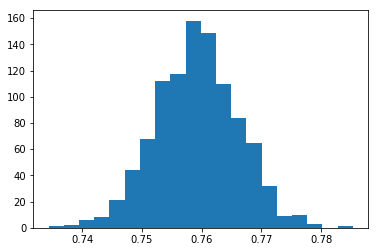

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis(solver='svd')
lda_ = runAlgorithm(model,1000)
print 'Accuracy: {}\nTime: {}'.format(*lda_[0])
plotDist(lda_[1],20)

## Quadratic Discriminant Analysis

Accuracy: 0.756185666667
Time: 0.00662580728531


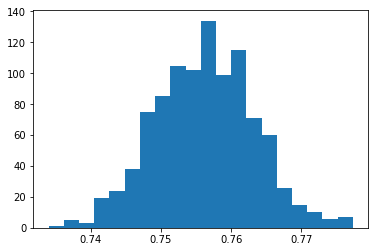

In [68]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model = QuadraticDiscriminantAnalysis()
qda_= runAlgorithm(model, 1000)
print 'Accuracy: {}\nTime: {}'.format(*qda_[0])
plotDist(qda_[1],20)

## Gradient Boost 

Accuracy: 0.74077
Time: 1.13194817543


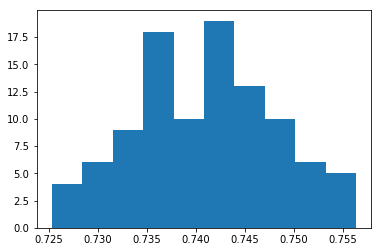

In [69]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

#start = time.time()
gbc = GBC(max_leaf_nodes=500, min_weight_fraction_leaf=0.001, min_samples_split=100, learning_rate=.4, max_features="auto")
grad = runAlgorithm(gbc, trials=100)
print 'Accuracy: {}\nTime: {}'.format(*grad[0])
plotDist(grad[1],10)

## MLP

Accuracy: 0.744033333333
Time: 7.70335625807


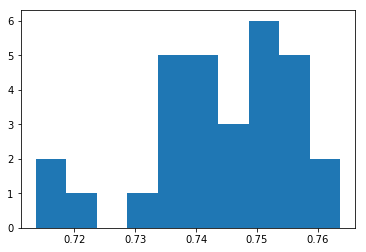

In [70]:
from sklearn.neural_network import MLPClassifier as mlp

start = time.time()
gbm = mlp(solver="lbfgs", activation='tanh', tol=1e-4, alpha=1e-5)#.fit(X_train,Y_train)
mlp_r = runAlgorithm(gbm, trials=30)
print 'Accuracy: {}\nTime: {}'.format(*mlp_r[0])
plotDist(mlp_r[1],10)

## Random Forests

Accuracy: 0.741713333333
Time: 2.35221369743


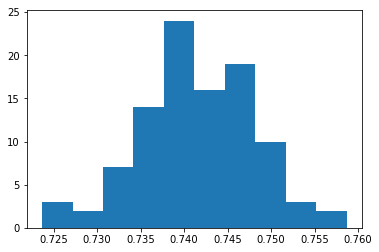

In [71]:
from sklearn.ensemble import RandomForestClassifier as RFC

rfc = RFC(min_samples_split=3, n_estimators =100)
forest = runAlgorithm(rfc, trials=100)
print 'Accuracy: {}\nTime: {}'.format(*forest[0])
plotDist(forest[1],10)

## Decision Tree

Accuracy: 0.663064666667
Time: 0.128382692814


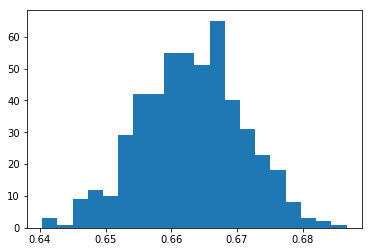

In [72]:
from sklearn.tree import DecisionTreeClassifier as DTC

dtc = DTC(criterion='entropy')
tree = runAlgorithm(dtc, trials=500)
print 'Accuracy: {}\nTime: {}'.format(*tree[0])
plotDist(tree[1],20)

## XGBoost

Accuracy: 0.748068666667
Time: 0.396643678665


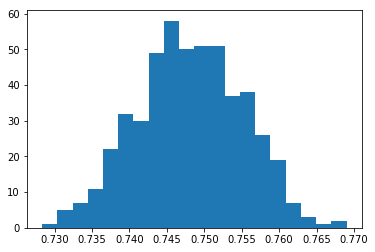

In [73]:
import xgboost as xgb
accuracy = []
times = []
for i in xrange(500):
    X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=.2)
    start = time.time()
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test)

    param = {'objective':'multi:softmax', 'num_class':5,'normalize_type':'forest','rate_drop':1, 'lambda':50, 'alpha':10}
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dtest) > .5
    accuracy.append((preds == y_test).mean())
    times.append(time.time() -start)
    #print preds

xgb_r = (np.mean(accuracy), np.mean(times)),accuracy
print 'Accuracy: {}\nTime: {}'.format(*xgb_r[0])
plotDist(xgb_r[1], 20)

# Model Comparison

In [80]:
comps = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Time'])
comps['Algorithm'] = ['Baseline', 'SVM', 'Logistic Regression', 'Ridge Regression', 
                      'Gradient Boost', 'XGBoost',
                      'MLP', 'Decision Tree', 'Random Forest', 'LDA', 'QDA']

results = [baseline_, svm_r, log_reg, rid_reg, grad, xgb_r, mlp_r, tree, forest, lda_, qda_]
comps['Accuracy'] = [m[0][0] for m in results]
comps['Time'] = [m[0][1] for m in results]

comps.sort_values('Accuracy', ascending=False).reset_index(drop=True)

,Algorithm,Accuracy,Time
0,Logistic Regression,0.759353,0.037792
1,LDA,0.759242,0.008268
2,Ridge Regression,0.759166,0.043255
3,QDA,0.756186,0.006626
4,XGBoost,0.748069,0.396644
5,MLP,0.744033,7.703356
6,Random Forest,0.741713,2.352214
7,Gradient Boost,0.740770,1.131948
8,Decision Tree,0.663065,0.128383
9,SVM,0.661773,4.616042


In [81]:
comps.sort_values('Time').reset_index(drop=True)

,Algorithm,Accuracy,Time
0,Baseline,0.597800,0.000546
1,QDA,0.756186,0.006626
2,LDA,0.759242,0.008268
3,Logistic Regression,0.759353,0.037792
4,Ridge Regression,0.759166,0.043255
5,Decision Tree,0.663065,0.128383
6,XGBoost,0.748069,0.396644
7,Gradient Boost,0.740770,1.131948
8,Random Forest,0.741713,2.352214
9,SVM,0.661773,4.616042


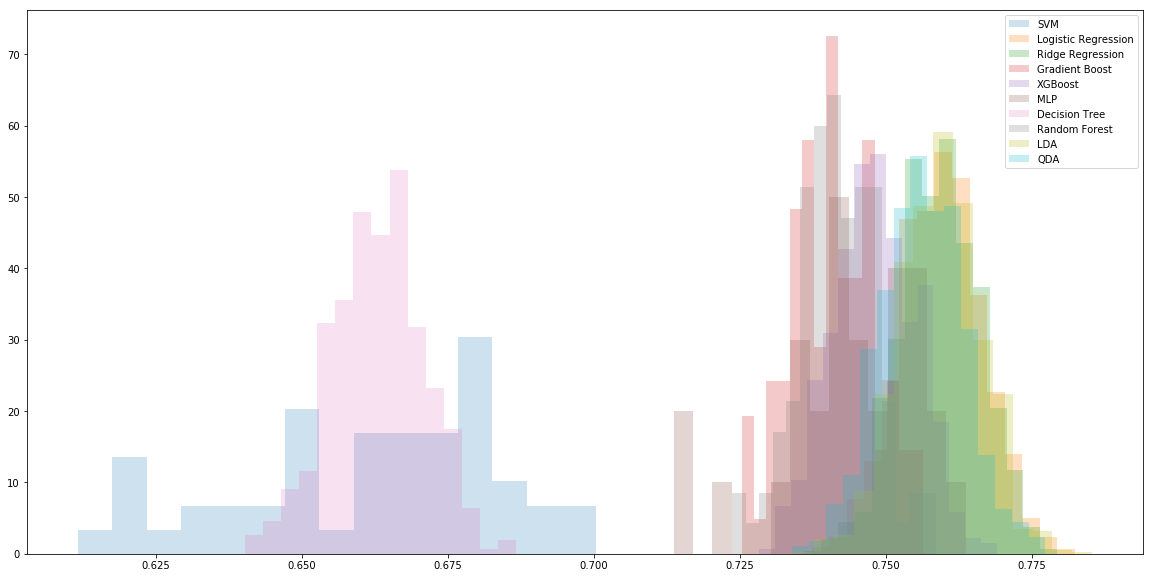

In [100]:
plt.figure(figsize=(20,10))
i = 1
for model in results[1:]:
    lab = comps['Algorithm'][i]
    trans = comps['Accuracy'][i]
    i+=1
    plt.hist(model[1],alpha=trans/3.,bins=15,label=lab,normed=True)
plt.legend()
plt.show()

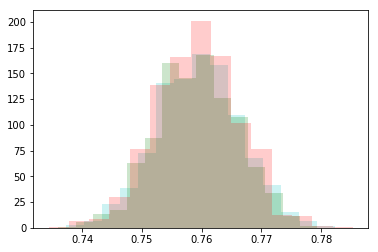

In [102]:
plt.hist(log_reg[1],color='c',alpha=0.2,bins=15)
plt.hist(rid_reg[1],color='g',alpha=0.2,bins=15)
plt.hist(lda_[1],color='r',alpha=0.2,bins=15)
plt.show()

## Evaluate accuracy and effectiveness of the methods you used and compare the relative strengths and weaknesses of each method for this particular project.  

The methods that we focused on were regression based methods, tree based methods, neural nets, and SVMs. 

### Regression based
Methods used: Logistic Regression, Ridge Regression

Both methods worked extremely well, with accuracies around 76% and running in only ~.03 seconds.  Note that logistic regression is really just a classifier, meaning the output is 1 or 0.  However, ridge regression outputs a continuous variable. Since a regression algorithm returns a continuous output, we set a threshold value of .5.  In other words, if the model returns a number greater than .5, we classified this as 1 or True.

### Tree based
Methods used: Decision Tree, Random Forest, Gradient Boost, XGBoost

Random Forests ran about as accurately as some of our better performers at 74%, but is a much slower method running in about a second and a half.

As expected, Decision Trees ran less accurately than Random Forests at 67% but runs much faster at ~.1 seconds. Decision Trees are one of the fasted methods we tested.

XGBoost was among the best of the tree methods, both fast and respectably accurate.  However, we could not quite get it to surpass the regression methods in accuracy, and those take only half the time.

Gradient Boost performed just under XGBoost both in time and accuracy.


### Gaussian Discriminant Analysis
Methods used: Linear Discriminant Analysis, Quadratic Discriminant Analysis

Despite their simplicity and the lack of parameters to tune, these two methods both achieve accuracy above 75% and run quickly. They are not quite as accurate as the regression methods, but they are about an order of magnitude faster. The fact that this works so well suggests that the wins and losses are somewhat linearly separable.


### Neural nets
Methods used: MLP

Our Multi Layer Perception (MLP) was as accurate as many of our top performers at ~75%, but was by far our slowest algorithm taking nearly 7.5 seconds to run. As such even though it is accurate, we would not choose to continue working with it because it is so much slower than other algorithms that are equally accurate.

### SVM
Our Support Vector Machine ran the worst accuracy out of any of our other methods at 65%. It also was our second slowest methods running at nearly 3 seconds. Because it was outperformed by almost all of our other tests in both categories, we will not continue working with this method.

# Algorithms we chose not to use

### Nearest neighbor

Due to the fact that we are not performing any kind of cluster analysis, we have decided the NN-classifying and NN-regression algorithms are not useful. 

### Mixture models with latent variables (train with EM)

Because there is not an unknown distribution in our dataset, mixture models along with EM will not work with our data set.


### Kalman Filters

Our data is not a true time series because we are not interested in how teams' overall performances changes over time. Games are decided strictly by winners and losers, so there is not any measurable error or noise. Because of this we have determined that it will not be useful in our methods. 

### AR, MA, ARMA, ARIMA time series models

Because these models are trying to describe certain time-varying processes of a time series, they will not be helpful in trying to predict wins and losses of specific games. 

# Summary

Basketball game outcomes are very unreliable.  Even a team that has performed well for the last few games can suddenly and inexplicably lose to a team that has been performing poorly; and this happens not infrequently.  Due to these vagaries, we feel that 75% accuracy is quite reasonable for this stage of our project.  We hope to improve on this over the next month by including more features in our data, namely team statistics: free throws, shots attempted, steals, percentages, and so forth.

# New Methods

## SVR
Epsilon-Support Vector Regression. Support Vector Regression (SVR) attempts to minimize the generalization error bound so as to achieve generalized performance. The idea of SVR is based on the computation of a linear regression function in a high dimensional feature space where the input data are mapped via a nonlinear function.

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Accuracy: 0.593683333333
Time: 4.14188535213


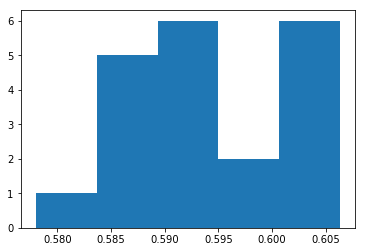

In [103]:
from sklearn import svm
from sklearn import preprocessing


accuracy = []
times = []
for i in xrange(20):
    X = preprocessing.scale(data)
    X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=.2)
    
    s = time.time()
    SVR_model = svm.SVR(C=10**-7, epsilon=.1, kernel='poly', coef0=-2, gamma=10**-4).fit(X_train, y_train)
#     SVR_model = svm.SVR().fit(X_train, y_train)
    preds = SVR_model.predict(X_test) <= 0
#     print preds
    prob = 1.*np.sum(preds == y_test)/len(y_test)
    times.append(time.time() - s)
    accuracy.append(prob)

svm_r = ((np.mean(accuracy), np.mean(times)),accuracy)
print 'Accuracy: {}\nTime: {}'.format(*svm_r[0])
plotDist(svm_r[1],5)

## Orthogonal Matching Pursuit (OMP)
A sparse approximation algorithm which involves finding the "best matching" projections of multidimensional data onto the span of an over-complete dictionary D. After every step, all the coefficients extracted so far are updated, by computing the orthogonal projection of the signal onto the set of points selected so far.

Accuracy: 0.758036
Time: 0.00276324558258


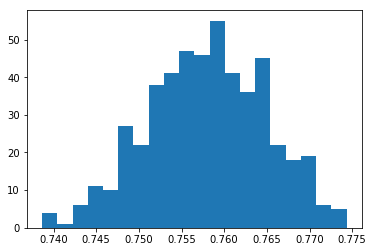

In [104]:
from sklearn import linear_model as lm

model = lm.OrthogonalMatchingPursuit(n_nonzero_coefs=7, precompute=True)
omp = runAlgorithm(model, trials=500)
print 'Accuracy: {}\nTime: {}'.format(*omp[0])
plotDist(omp[1],20)

## Extra Trees Classifier

An “extra trees” classifier, otherwise known as an “Extremely randomized trees” classifier, is a variant of a random forest. Unlike a random forest, at each step the entire sample is used and decision boundaries are picked at random, rather than the best one. In real world cases, performance is comparable to an ordinary random forest, sometimes better.

Accuracy: 0.74385
Time: 1.43858869553


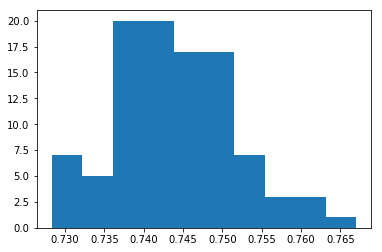

In [105]:
from sklearn.ensemble import ExtraTreesClassifier
extraforest = ExtraTreesClassifier(n_estimators=100, oob_score=True, bootstrap=True)

xtrees = runAlgorithm(extraforest,trials=100)
print 'Accuracy: {}\nTime: {}'.format(*xtrees[0])
plotDist(xtrees[1],10)

## Bayesian Ridge Regression

Estimates a probabilistic model of the regression problem as described above. The prior for the parameter w is given by a spherical Gaussian. The priors over alpha and lambda are chosen to be gamma distributions, the conjugate prior for the precision of the Gaussian. The parameters are estimated by maximizing the marginal log likelihood.

Accuracy: 0.758786
Time: 0.00422581386566


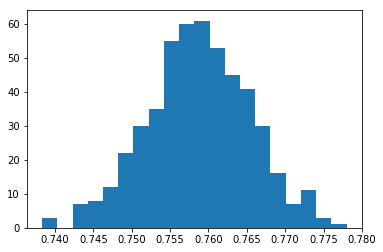

In [106]:
from sklearn import linear_model as lm

model = lm.BayesianRidge()
bayes_ridge = runAlgorithm(model, trials=500)
print 'Accuracy: {}\nTime: {}'.format(*bayes_ridge[0])
plotDist(bayes_ridge[1],20)

## Voting Classifier

A Voting Classifier is used to employ multiple individual classifiers and combine their predictions, which could achieve better performance than a single classifier.

In [107]:
from sklearn.ensemble import VotingClassifier

vote_model = VotingClassifier(estimators=[('lr', model),('LDA',model2),('QDA',modelQDA)], voting='soft')
voting = runAlgorithm(vote_model, trials=500)
print 'Accuracy: {}\nTime: {}'.format(*voting[0])
plotDist(voting[1],20)

NameError: name 'model2' is not defined

In [109]:
comps = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Time'])
comps['Algorithm'] = ['Baseline', 'SVM', 'Logistic Regression', 'Ridge Regression', 
                      'Gradient Boost', 'XGBoost',
                      'MLP', 'Decision Tree', 'Random Forest', 'LDA', 'QDA',
                      'SVR', 'OMP', 'ExtremeTrees', 'Bayes Ridge', 'Voting']

results = [baseline_, svm_r, log_reg, rid_reg, grad, xgb_r, mlp_r, tree, forest, lda_, qda_,
           svm_r, omp, xtrees, bayes_ridge, voting]

comps['Accuracy'] = [m[0][0] for m in results]
comps['Time'] = [m[0][1] for m in results]

comps.sort_values('Accuracy', ascending=False).reset_index(drop=True)

NameError: name 'voting' is not defined

In [108]:
comps.sort_values('Time').reset_index(drop=True)

,Algorithm,Accuracy,Time
0,Baseline,0.597800,0.000546
1,QDA,0.756186,0.006626
2,LDA,0.759242,0.008268
3,Logistic Regression,0.759353,0.037792
4,Ridge Regression,0.759166,0.043255
5,Decision Tree,0.663065,0.128383
6,XGBoost,0.748069,0.396644
7,Gradient Boost,0.740770,1.131948
8,Random Forest,0.741713,2.352214
9,SVM,0.661773,4.616042
